# Fine Tuning the Resnet for Optimization Of Results

This notebook will comprise some small suggested changes, as an attempt to create a simple but efficient ResNet training loop.

Throughout this file, I will implement:

 - Best validation loss model output, to maximize model performance
 - Unfreezing layers, as an attempt to allow the ResNet to adapt to the dataset
 - Adding performance metrics and plotting ROC/AUC for the test dataframe, for more thorough evaluation
 - Resizing tensors before augmentations, to increase training speed 

Firstly, I will import code snippets from `resnetEval.ipynb`:

In [82]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from scipy.ndimage import gaussian_filter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import random
import math
import copy
import os


# -----------  ResNet -----------

# Core library
import torch

# Essentials for development
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Data resize (ResNet uses (224,224) inputs)
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

# Allows for paralell batch processing
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import decode_image

# Data Loader Design

The first step in optimization has already been implemented: resizing before applying augmentations.

In [5]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds random set of augmentations
        if self.albumentations:
            # Applies resize prior to augmentations
            # Could hinder scan quality, but drastically improves training speed
            resize = transforms.Resize((224, 224))
            image = resize(image)
            augmented = self.albumentations(image=image)
            image = augmented['image']

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

## Main Functions

**trainResNet** is the next subject to change. First, I must evaluate which is the best option:

```py

    # Considers only absolute lowest val_loss value
    best_model_pure = resnet18

    # Considers balance between good loss value and reasonable training loss
    best_model_conservative = resnet18

```

The first option should be more prone to overfitting. For this reason, I will be evaluating if defining a threshold for loss improvement in model choice results in better performance.

### Best Model Result

In [103]:
def trainResNet(train_dataset, val_dataset, num_epochs=70, batch_size=32, lr=5e-7, patience=5, improve_min=0.001, threshold1=0.03, threshold2=0.55):
    # New ResNet instance
    resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    # Considers only absolute lowest val_loss value
    best_model_pure = copy.deepcopy(resnet18)
    best_val_pure, epoch_pure = 10, 0

    # Considers balance between good loss value and reasonable training loss
    best_model_conservative = copy.deepcopy(resnet18)
    best_val_conservative, epoch_conservative = 10, 0

    # Use only 2 output neurons
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 2)  

    # If graphics card is available, uses it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)

    print("*"+("-"*29)+"*")
    print("|{:^29}|".format(f"Using {device}"))
    print("*"+("-"*29)+"*")

    # Generate data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Loss function 
    criterion = nn.CrossEntropyLoss()  
    # ADAM
    optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

    # add learning_rate_scheduler e step learning rate

    # Initializing early stop counter (based on validation loss)
    best_loss = 10
    early_stop_ctr = 0

    loss_array = []
    val_loss_array = []


    for epoch in range(num_epochs):
        resnet18.train()
        running_loss = 0.0
        running_val_loss = 0.0


        # --------------- Weight updates ---------------
        
        # Iterates over each image in dataset, updates weights
        for images, labels in tqdm((train_loader), desc = "Training..."):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Computes average training loss
        avg_loss_train = running_loss/len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {avg_loss_train:.6f}")
        loss_array.append(avg_loss_train)


        # ---------------- Validation Loss -----------------

        # Iterates over each image in dataset, computes validation loss
        for images, labels in (val_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            val_loss = criterion(outputs, labels)
            
            running_val_loss += val_loss.item()

        # Computes average validation loss
        avg_loss_val = running_val_loss/len(val_loader)
        print(f"Validation loss: {avg_loss_val:.6f}")
        val_loss_array.append(avg_loss_val)


        # ------------------ Best Model -------------------

        # Thresholds determined through experimentation 
        # threshold1 -> usually where val begins to plateau
        # threshold2 -> usually where train begins to overfit
        if epoch >= 35:
            if avg_loss_val < best_val_pure:
                best_val_pure = avg_loss_val
                best_model_pure = copy.deepcopy(resnet18)
                epoch_pure = epoch
            
            # If saved val loss is >= 1.03 times current value, updates
            # But only if train loss is >= 70% of the current val loss
            if (best_val_conservative > avg_loss_val * (1 + threshold1)) and (avg_loss_train >= avg_loss_val * threshold2):
                best_val_conservative = avg_loss_val
                best_model_conservative = copy.deepcopy(resnet18)
                epoch_conservative = epoch
        
        
        # ---------------- Early Stopping -----------------

        # Only after a high number of epochs (around 60)
        if epoch > 60:
            # Check for improvement (1% standard)
            if abs(best_loss - avg_loss_val) > (best_loss * improve_min):
                best_loss = avg_loss_val
                early_stop_ctr = 0
            else: early_stop_ctr += 1

            # Checks early stopping condition
            if early_stop_ctr >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!!!")
                break
    
    return (best_model_pure, epoch_pure), (best_model_conservative, epoch_conservative), loss_array, val_loss_array

In [43]:
def savePickles(custom_loss, custom_val_loss):
    with open(r'pickleJar\custom_loss.pkl', 'wb') as f:
        pickle.dump(custom_loss, f)

    with open(r'pickleJar\custom_val_loss.pkl', 'wb') as f:
        pickle.dump(custom_val_loss, f)

In [58]:
def saveRun(pure_vs_conservative, base_path):
    for i, run in enumerate(pure_vs_conservative):
        pair_pure, pair_cons, train_loss, val_loss = run
        folder_path = os.path.join(base_path, f"iteration_{i}")
        os.makedirs(folder_path, exist_ok=True)

        model_pure, epoch_pure = pair_pure
        model_cons, epoch_cons = pair_cons

        # Save model states
        torch.save({
            'model_state_dict': model_pure.state_dict(),
            'epoch': epoch_pure,
            'train_loss': train_loss,
            'val_loss': val_loss
        }, os.path.join(folder_path, 'pure_model.pt'))

        torch.save({
            'model_state_dict': model_cons.state_dict(),
            'epoch': epoch_cons,
            'train_loss': train_loss,
            'val_loss': val_loss
        }, os.path.join(folder_path, 'cons_model.pt'))

        # Save metadata
        metadata = {
            'epoch_pure': epoch_pure,
            'epoch_cons': epoch_cons,
            'train_loss': train_loss,
            'val_loss': val_loss
        }
        with open(os.path.join(folder_path, 'metadata.pkl'), 'wb') as f:
            pickle.dump(metadata, f)

### Generate ROC and Best Threshold

In [44]:
def getROC(model, val_dataset): 

    all_labels, all_scores = [], []
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # Translate logits to Class 1 probabilities using softmax
            # (pulls column 1 values and assigns probabilities)
            probs = F.softmax(outputs, dim=1)[:, 1]  

            all_scores.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    # Compute distance to (0,1) for each point on the ROC curve
    distances = np.sqrt((fpr)**2 + (1 - tpr)**2)

    # Gets closest point to the perfect discriminator (0,1)
    best_idx = np.argmin(distances)
    best_threshold = thresholds[best_idx]

    # ---------- Display and Results ---------- 

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print("Area Under Curve:", roc_auc)
    print("Best Threshold (closest to (0,1)):", best_threshold)

    return best_threshold, roc_auc


### Loss Evolution

In [85]:
def plotLoss(train_loss, val_loss, best_pure_epoch=False, best_cons_epoch=False):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='x')

    # Add purple dot for best pure epoch
    if best_pure_epoch:
        plt.scatter(best_pure_epoch + 1, val_loss[best_pure_epoch], color='purple', label='Best Pure', zorder=5)
        plt.text(best_pure_epoch + 1, val_loss[best_pure_epoch] + 0.01, 'pure', color='purple')

    # Add green dot for best conservative epoch
    if best_cons_epoch:
        plt.scatter(best_cons_epoch + 1, val_loss[best_cons_epoch], color='green', label='Best Conservative', zorder=5)
        plt.text(best_cons_epoch + 1, val_loss[best_cons_epoch] + 0.01, 'conservative', color='green')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [100]:
def plotLossAX(train_loss, val_loss, best_pure_epoch=False, best_cons_epoch=False, iter=0, ax="no"):
    epochs = range(1, len(train_loss) + 1)

    ax.plot(epochs, train_loss, label='Train Loss', marker='o')
    ax.plot(epochs, val_loss, label='Validation Loss', marker='x')

    # Add purple dot for best pure epoch
    if best_pure_epoch:
        ax.scatter(best_pure_epoch + 1, val_loss[best_pure_epoch], color='purple', label='Best Pure', zorder=5)
        ax.text(best_pure_epoch + 1, val_loss[best_pure_epoch] + 0.01, 'pure', color='purple')

    # Add green dot for best conservative epoch
    if best_cons_epoch is not False:
        ax.scatter(best_cons_epoch + 1, val_loss[best_cons_epoch], color='green', label='Best Conservative', zorder=5)
        ax.text(best_cons_epoch + 1, val_loss[best_cons_epoch] + 0.01, 'conservative', color='green')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [101]:
def plotLossCollection(all_train, all_val, best_pure_epochs, best_cons_epochs):
    n = len(all_train)
    cols = 2
    rows = math.ceil(n / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axs = axs.flatten() 

    for i in range(n):
        plotLossAX(all_train[i], all_val[i], best_pure_epochs[i], best_cons_epochs[i], iter=i, ax=axs[i])

    # Hide unused subplots
    for j in range(n, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


In [47]:
def evalResNet(resnet18, test_dataset, threshold):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []


    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Translate prob vs threshold to predictions
            # True if prob >= threshold else False
            # .long() transforms True/False to 1/0
            predicted = (probs >= threshold).long()
            
            # Update total and correct for general accuracy
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            # Class-specific accuracy
            for label, pred in zip(labels, predicted):
                if label == 0:
                    total_class_0 += 1
                    if pred == label:
                        correct_class_0 += 1
                elif label == 1:
                    total_class_1 += 1
                    if pred == label:
                        correct_class_1 += 1

            # Add data to lists
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())



    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)

## Custom Split (No Augmentations)

In [48]:
# Defining paths
train_df = r"trainTestCustom\train.csv"
test_df = r"trainTestCustom\test.csv"
val_df = r"trainTestCustom\val.csv"

In [49]:
# Paths
img_dir = r'..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = train_df
annotations_file_test = test_df
annotations_file_val = val_df


# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

For results validity, the pure vs conservative test will be performed 5 times:

In [ ]:
models_path = "..\\..\\trainedResNets\\improvedVersion\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    pure_vs_conservative = []

    for i in range(5):
        # Get both models for the current iteration
        pair_pure, pair_conservative, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

        # Add them to the list
        cur = [pair_pure, pair_conservative, custom_loss, custom_val_loss]
        pure_vs_conservative.append(cur)

elif ans == "read":
    # Read from images
    pass

    
else: print("Invalid answer, try again.")

*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.10it/s]


Epoch [1/70], Train loss: 0.743886
Validation loss: 0.741430


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.59it/s]


Epoch [2/70], Train loss: 0.709489
Validation loss: 0.722522


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.57it/s]


Epoch [3/70], Train loss: 0.680953
Validation loss: 0.704687


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.57it/s]


Epoch [4/70], Train loss: 0.650745
Validation loss: 0.689507


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.73it/s]


Epoch [5/70], Train loss: 0.628665
Validation loss: 0.675403


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [6/70], Train loss: 0.602100
Validation loss: 0.661744


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [7/70], Train loss: 0.581259
Validation loss: 0.649446


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [8/70], Train loss: 0.561052
Validation loss: 0.637981


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [9/70], Train loss: 0.540293
Validation loss: 0.628036


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.59it/s]


Epoch [10/70], Train loss: 0.525737
Validation loss: 0.618147


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.70it/s]


Epoch [11/70], Train loss: 0.510913
Validation loss: 0.608195


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.57it/s]


Epoch [12/70], Train loss: 0.495347
Validation loss: 0.598372


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [13/70], Train loss: 0.479097
Validation loss: 0.589918


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s]


Epoch [14/70], Train loss: 0.464450
Validation loss: 0.581014


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s]


Epoch [15/70], Train loss: 0.452301
Validation loss: 0.572005


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.26it/s]


Epoch [16/70], Train loss: 0.439271
Validation loss: 0.565274


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.77it/s]


Epoch [17/70], Train loss: 0.427062
Validation loss: 0.557418


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [18/70], Train loss: 0.415809
Validation loss: 0.550329


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.69it/s]


Epoch [19/70], Train loss: 0.402831
Validation loss: 0.543796


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.73it/s]


Epoch [20/70], Train loss: 0.389119
Validation loss: 0.537079


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [21/70], Train loss: 0.380271
Validation loss: 0.531446


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.09it/s]


Epoch [22/70], Train loss: 0.368305
Validation loss: 0.524884


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.73it/s]


Epoch [23/70], Train loss: 0.357613
Validation loss: 0.519149


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.94it/s]


Epoch [24/70], Train loss: 0.354739
Validation loss: 0.513554


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.69it/s]


Epoch [25/70], Train loss: 0.342435
Validation loss: 0.508203


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.63it/s]


Epoch [26/70], Train loss: 0.328777
Validation loss: 0.503213


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.57it/s]


Epoch [27/70], Train loss: 0.322219
Validation loss: 0.498233


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.63it/s]


Epoch [28/70], Train loss: 0.320257
Validation loss: 0.493436


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.97it/s]


Epoch [29/70], Train loss: 0.307448
Validation loss: 0.489201


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [30/70], Train loss: 0.303127
Validation loss: 0.484578


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [31/70], Train loss: 0.288963
Validation loss: 0.480848


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.68it/s]


Epoch [32/70], Train loss: 0.284799
Validation loss: 0.477118


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [33/70], Train loss: 0.277596
Validation loss: 0.472783


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [34/70], Train loss: 0.266580
Validation loss: 0.469482


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [35/70], Train loss: 0.265272
Validation loss: 0.465576


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [36/70], Train loss: 0.257883
Validation loss: 0.462558


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.97it/s]


Epoch [37/70], Train loss: 0.251339
Validation loss: 0.459651


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [38/70], Train loss: 0.244340
Validation loss: 0.455858


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.95it/s]


Epoch [39/70], Train loss: 0.243433
Validation loss: 0.453359


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.75it/s]


Epoch [40/70], Train loss: 0.256298
Validation loss: 0.450432


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.63it/s]


Epoch [41/70], Train loss: 0.233491
Validation loss: 0.448404


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.59it/s]


Epoch [42/70], Train loss: 0.224460
Validation loss: 0.446615


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.45it/s]


Epoch [43/70], Train loss: 0.228618
Validation loss: 0.444608


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.02it/s]


Epoch [44/70], Train loss: 0.216242
Validation loss: 0.442705


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.73it/s]


Epoch [45/70], Train loss: 0.208060
Validation loss: 0.440148


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.79it/s]


Epoch [46/70], Train loss: 0.208425
Validation loss: 0.438457


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.61it/s]


Epoch [47/70], Train loss: 0.203880
Validation loss: 0.436410


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.02it/s]


Epoch [48/70], Train loss: 0.195365
Validation loss: 0.434405


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.99it/s]


Epoch [49/70], Train loss: 0.187985
Validation loss: 0.432813


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [50/70], Train loss: 0.189597
Validation loss: 0.432100


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [51/70], Train loss: 0.185729
Validation loss: 0.429795


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [52/70], Train loss: 0.178708
Validation loss: 0.428751


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [53/70], Train loss: 0.179547
Validation loss: 0.427217


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [54/70], Train loss: 0.171524
Validation loss: 0.426454


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [55/70], Train loss: 0.170834
Validation loss: 0.424667


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.12it/s]


Epoch [56/70], Train loss: 0.168462
Validation loss: 0.423951


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [57/70], Train loss: 0.164881
Validation loss: 0.422540


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [58/70], Train loss: 0.158189
Validation loss: 0.421396


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [59/70], Train loss: 0.156245
Validation loss: 0.421016


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [60/70], Train loss: 0.148046
Validation loss: 0.421149


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [61/70], Train loss: 0.151899
Validation loss: 0.420681


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.12it/s]


Epoch [62/70], Train loss: 0.143711
Validation loss: 0.419626


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.12it/s]


Epoch [63/70], Train loss: 0.142197
Validation loss: 0.419081


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [64/70], Train loss: 0.143160
Validation loss: 0.417621


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.09it/s]


Epoch [65/70], Train loss: 0.134484
Validation loss: 0.417123


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.79it/s]


Epoch [66/70], Train loss: 0.131101
Validation loss: 0.417763


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [67/70], Train loss: 0.130776
Validation loss: 0.417962


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [68/70], Train loss: 0.134179
Validation loss: 0.417829


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s]


Epoch [69/70], Train loss: 0.125610
Validation loss: 0.418311


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [70/70], Train loss: 0.124133
Validation loss: 0.417674
*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s]


Epoch [1/70], Train loss: 0.513215
Validation loss: 0.493598


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.36it/s]


Epoch [2/70], Train loss: 0.488478
Validation loss: 0.487475


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.30it/s]


Epoch [3/70], Train loss: 0.465012
Validation loss: 0.482067


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.26it/s]


Epoch [4/70], Train loss: 0.448595
Validation loss: 0.477089


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [5/70], Train loss: 0.432183
Validation loss: 0.472411


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s]


Epoch [6/70], Train loss: 0.416405
Validation loss: 0.468288


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [7/70], Train loss: 0.403362
Validation loss: 0.463883


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.28it/s]


Epoch [8/70], Train loss: 0.391044
Validation loss: 0.459738


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [9/70], Train loss: 0.377625
Validation loss: 0.456450


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [10/70], Train loss: 0.368386
Validation loss: 0.452914


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.29it/s]


Epoch [11/70], Train loss: 0.359151
Validation loss: 0.449756


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [12/70], Train loss: 0.347225
Validation loss: 0.446579


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.28it/s]


Epoch [13/70], Train loss: 0.335650
Validation loss: 0.443412


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [14/70], Train loss: 0.340644
Validation loss: 0.440702


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [15/70], Train loss: 0.318579
Validation loss: 0.437640


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [16/70], Train loss: 0.312436
Validation loss: 0.435130


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [17/70], Train loss: 0.303765
Validation loss: 0.432478


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [18/70], Train loss: 0.296269
Validation loss: 0.430124


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [19/70], Train loss: 0.288610
Validation loss: 0.428163


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [20/70], Train loss: 0.290823
Validation loss: 0.425628


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [21/70], Train loss: 0.279455
Validation loss: 0.423558


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [22/70], Train loss: 0.271610
Validation loss: 0.422130


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [23/70], Train loss: 0.271955
Validation loss: 0.420298


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [24/70], Train loss: 0.258320
Validation loss: 0.418925


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [25/70], Train loss: 0.252183
Validation loss: 0.417208


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [26/70], Train loss: 0.247035
Validation loss: 0.415587


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.27it/s]


Epoch [27/70], Train loss: 0.256063
Validation loss: 0.414055


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.26it/s]


Epoch [28/70], Train loss: 0.242143
Validation loss: 0.412060


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [29/70], Train loss: 0.234281
Validation loss: 0.410977


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [30/70], Train loss: 0.234590
Validation loss: 0.409697


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [31/70], Train loss: 0.223949
Validation loss: 0.408916


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [32/70], Train loss: 0.218261
Validation loss: 0.407837


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.15it/s]


Epoch [33/70], Train loss: 0.214104
Validation loss: 0.406847


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [34/70], Train loss: 0.214901
Validation loss: 0.405771


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [35/70], Train loss: 0.207078
Validation loss: 0.405281


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [36/70], Train loss: 0.203319
Validation loss: 0.404260


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [37/70], Train loss: 0.198676
Validation loss: 0.403823


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.08it/s]


Epoch [38/70], Train loss: 0.194133
Validation loss: 0.402616


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [39/70], Train loss: 0.189861
Validation loss: 0.402212


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.02it/s]


Epoch [40/70], Train loss: 0.185382
Validation loss: 0.401254


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [41/70], Train loss: 0.186802
Validation loss: 0.400747


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [42/70], Train loss: 0.180069
Validation loss: 0.400264


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.07it/s]


Epoch [43/70], Train loss: 0.183467
Validation loss: 0.399569


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [44/70], Train loss: 0.185093
Validation loss: 0.398797


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [45/70], Train loss: 0.171353
Validation loss: 0.398921


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [46/70], Train loss: 0.164591
Validation loss: 0.398591


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [47/70], Train loss: 0.165456
Validation loss: 0.398466


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [48/70], Train loss: 0.159753
Validation loss: 0.398264


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [49/70], Train loss: 0.159246
Validation loss: 0.398000


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [50/70], Train loss: 0.156348
Validation loss: 0.397613


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [51/70], Train loss: 0.159522
Validation loss: 0.397505


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.07it/s]


Epoch [52/70], Train loss: 0.148701
Validation loss: 0.398194


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [53/70], Train loss: 0.145896
Validation loss: 0.398081


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [54/70], Train loss: 0.150683
Validation loss: 0.398095


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [55/70], Train loss: 0.146741
Validation loss: 0.397112


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [56/70], Train loss: 0.136033
Validation loss: 0.398298


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.12it/s]


Epoch [57/70], Train loss: 0.136214
Validation loss: 0.398626


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [58/70], Train loss: 0.136675
Validation loss: 0.398680


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [59/70], Train loss: 0.130967
Validation loss: 0.399524


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [60/70], Train loss: 0.129665
Validation loss: 0.399277


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.07it/s]


Epoch [61/70], Train loss: 0.127968
Validation loss: 0.399380


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [62/70], Train loss: 0.126019
Validation loss: 0.399660


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [63/70], Train loss: 0.123350
Validation loss: 0.398640


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [64/70], Train loss: 0.121497
Validation loss: 0.399013


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.09it/s]


Epoch [65/70], Train loss: 0.121292
Validation loss: 0.399645


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.06it/s]


Epoch [66/70], Train loss: 0.111549
Validation loss: 0.400027


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [67/70], Train loss: 0.122789
Validation loss: 0.400525


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [68/70], Train loss: 0.109730
Validation loss: 0.402264


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [69/70], Train loss: 0.118842
Validation loss: 0.402388


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.15it/s]


Epoch [70/70], Train loss: 0.114564
Validation loss: 0.403441
*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [1/70], Train loss: 0.599058
Validation loss: 0.578325


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [2/70], Train loss: 0.564629
Validation loss: 0.568175


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [3/70], Train loss: 0.540487
Validation loss: 0.558937


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [4/70], Train loss: 0.525119
Validation loss: 0.550436


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [5/70], Train loss: 0.499552
Validation loss: 0.543182


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [6/70], Train loss: 0.483482
Validation loss: 0.536084


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.15it/s]


Epoch [7/70], Train loss: 0.471233
Validation loss: 0.529224


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s]


Epoch [8/70], Train loss: 0.453577
Validation loss: 0.523132


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [9/70], Train loss: 0.438639
Validation loss: 0.516845


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [10/70], Train loss: 0.424176
Validation loss: 0.510902


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.28it/s]


Epoch [11/70], Train loss: 0.412338
Validation loss: 0.505396


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s]


Epoch [12/70], Train loss: 0.398895
Validation loss: 0.500010


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.26it/s]


Epoch [13/70], Train loss: 0.388725
Validation loss: 0.494734


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s]


Epoch [14/70], Train loss: 0.377317
Validation loss: 0.489679


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [15/70], Train loss: 0.364097
Validation loss: 0.485247


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [16/70], Train loss: 0.355780
Validation loss: 0.480483


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [17/70], Train loss: 0.345318
Validation loss: 0.475848


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [18/70], Train loss: 0.338091
Validation loss: 0.472126


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.28it/s]


Epoch [19/70], Train loss: 0.327687
Validation loss: 0.467892


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s]


Epoch [20/70], Train loss: 0.320482
Validation loss: 0.464318


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [21/70], Train loss: 0.314140
Validation loss: 0.460758


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.28it/s]


Epoch [22/70], Train loss: 0.302814
Validation loss: 0.456950


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [23/70], Train loss: 0.313671
Validation loss: 0.453601


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [24/70], Train loss: 0.290341
Validation loss: 0.451198


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [25/70], Train loss: 0.305023
Validation loss: 0.448061


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [26/70], Train loss: 0.277559
Validation loss: 0.446078


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.26it/s]


Epoch [27/70], Train loss: 0.273755
Validation loss: 0.443244


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [28/70], Train loss: 0.264971
Validation loss: 0.441389


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [29/70], Train loss: 0.257181
Validation loss: 0.439755


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s]


Epoch [30/70], Train loss: 0.259912
Validation loss: 0.437138


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [31/70], Train loss: 0.252392
Validation loss: 0.435387


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [32/70], Train loss: 0.244408
Validation loss: 0.433810


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [33/70], Train loss: 0.238800
Validation loss: 0.431575


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [34/70], Train loss: 0.232533
Validation loss: 0.429856


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [35/70], Train loss: 0.227700
Validation loss: 0.427970


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s]


Epoch [36/70], Train loss: 0.230313
Validation loss: 0.426171


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [37/70], Train loss: 0.214380
Validation loss: 0.424781


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [38/70], Train loss: 0.212103
Validation loss: 0.423426


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.07it/s]


Epoch [39/70], Train loss: 0.210159
Validation loss: 0.421885


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [40/70], Train loss: 0.204930
Validation loss: 0.420341


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [41/70], Train loss: 0.200612
Validation loss: 0.419042


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.07it/s]


Epoch [42/70], Train loss: 0.196406
Validation loss: 0.417819


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.76it/s]


Epoch [43/70], Train loss: 0.195781
Validation loss: 0.416673


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.06it/s]


Epoch [44/70], Train loss: 0.191552
Validation loss: 0.415823


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.05it/s]


Epoch [45/70], Train loss: 0.183485
Validation loss: 0.415908


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.07it/s]


Epoch [46/70], Train loss: 0.180139
Validation loss: 0.415019


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [47/70], Train loss: 0.183342
Validation loss: 0.414573


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [48/70], Train loss: 0.182119
Validation loss: 0.413667


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.06it/s]


Epoch [49/70], Train loss: 0.173985
Validation loss: 0.413704


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [50/70], Train loss: 0.167386
Validation loss: 0.412700


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [51/70], Train loss: 0.159589
Validation loss: 0.411752


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.06it/s]


Epoch [52/70], Train loss: 0.163769
Validation loss: 0.410820


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [53/70], Train loss: 0.153332
Validation loss: 0.410813


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.09it/s]


Epoch [54/70], Train loss: 0.154166
Validation loss: 0.410178


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [55/70], Train loss: 0.150387
Validation loss: 0.410019


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.06it/s]


Epoch [56/70], Train loss: 0.148142
Validation loss: 0.410515


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [57/70], Train loss: 0.147279
Validation loss: 0.409999


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [58/70], Train loss: 0.141019
Validation loss: 0.409216


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [59/70], Train loss: 0.138812
Validation loss: 0.409084


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [60/70], Train loss: 0.137033
Validation loss: 0.409052


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [61/70], Train loss: 0.139350
Validation loss: 0.408601


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [62/70], Train loss: 0.131417
Validation loss: 0.409250


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.09it/s]


Epoch [63/70], Train loss: 0.131033
Validation loss: 0.409327


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.06it/s]


Epoch [64/70], Train loss: 0.126263
Validation loss: 0.409290


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.06it/s]


Epoch [65/70], Train loss: 0.129685
Validation loss: 0.408833


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.12it/s]


Epoch [66/70], Train loss: 0.126100
Validation loss: 0.408930


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [67/70], Train loss: 0.120303
Validation loss: 0.409301


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [68/70], Train loss: 0.119779
Validation loss: 0.409739


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.08it/s]


Epoch [69/70], Train loss: 0.111218
Validation loss: 0.410818


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [70/70], Train loss: 0.116082
Validation loss: 0.410989
*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [1/70], Train loss: 1.401411
Validation loss: 1.398157


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [2/70], Train loss: 1.354290
Validation loss: 1.369055


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [3/70], Train loss: 1.306912
Validation loss: 1.341191


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [4/70], Train loss: 1.266643
Validation loss: 1.313322


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [5/70], Train loss: 1.225637
Validation loss: 1.286228


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [6/70], Train loss: 1.171212
Validation loss: 1.260074


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [7/70], Train loss: 1.146957
Validation loss: 1.235717


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [8/70], Train loss: 1.106506
Validation loss: 1.210633


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [9/70], Train loss: 1.074001
Validation loss: 1.186189


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [10/70], Train loss: 1.040049
Validation loss: 1.162383


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [11/70], Train loss: 0.995383
Validation loss: 1.139387


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [12/70], Train loss: 0.976046
Validation loss: 1.117252


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [13/70], Train loss: 0.940153
Validation loss: 1.095168


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [14/70], Train loss: 0.916677
Validation loss: 1.074246


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.15it/s]


Epoch [15/70], Train loss: 0.883663
Validation loss: 1.052818


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [16/70], Train loss: 0.855113
Validation loss: 1.032495


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [17/70], Train loss: 0.825843
Validation loss: 1.013305


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s]


Epoch [18/70], Train loss: 0.797649
Validation loss: 0.994527


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [19/70], Train loss: 0.770192
Validation loss: 0.975095


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [20/70], Train loss: 0.740692
Validation loss: 0.957189


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [21/70], Train loss: 0.730813
Validation loss: 0.940308


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [22/70], Train loss: 0.709492
Validation loss: 0.922660


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.26it/s]


Epoch [23/70], Train loss: 0.685087
Validation loss: 0.905669


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [24/70], Train loss: 0.654068
Validation loss: 0.889575


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s]


Epoch [25/70], Train loss: 0.643064
Validation loss: 0.874479


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [26/70], Train loss: 0.621052
Validation loss: 0.859210


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.27it/s]


Epoch [27/70], Train loss: 0.609292
Validation loss: 0.844501


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [28/70], Train loss: 0.585640
Validation loss: 0.831175


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.26it/s]


Epoch [29/70], Train loss: 0.569975
Validation loss: 0.816904


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [30/70], Train loss: 0.560889
Validation loss: 0.803088


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [31/70], Train loss: 0.536384
Validation loss: 0.789877


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [32/70], Train loss: 0.519932
Validation loss: 0.777259


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [33/70], Train loss: 0.503828
Validation loss: 0.764873


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [34/70], Train loss: 0.487239
Validation loss: 0.753113


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.15it/s]


Epoch [35/70], Train loss: 0.468669
Validation loss: 0.741850


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [36/70], Train loss: 0.462200
Validation loss: 0.731073


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.00it/s]


Epoch [37/70], Train loss: 0.452702
Validation loss: 0.720523


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [38/70], Train loss: 0.437607
Validation loss: 0.709908


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [39/70], Train loss: 0.425075
Validation loss: 0.700510


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [40/70], Train loss: 0.411294
Validation loss: 0.690625


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.08it/s]


Epoch [41/70], Train loss: 0.398446
Validation loss: 0.681574


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.07it/s]


Epoch [42/70], Train loss: 0.402731
Validation loss: 0.671555


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [43/70], Train loss: 0.373964
Validation loss: 0.662893


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.03it/s]


Epoch [44/70], Train loss: 0.368453
Validation loss: 0.655804


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [45/70], Train loss: 0.357996
Validation loss: 0.647554


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [46/70], Train loss: 0.349269
Validation loss: 0.641361


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [47/70], Train loss: 0.335809
Validation loss: 0.634395


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [48/70], Train loss: 0.329465
Validation loss: 0.627219


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.02it/s]


Epoch [49/70], Train loss: 0.318544
Validation loss: 0.619381


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [50/70], Train loss: 0.318144
Validation loss: 0.613431


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [51/70], Train loss: 0.309075
Validation loss: 0.606542


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.08it/s]


Epoch [52/70], Train loss: 0.300185
Validation loss: 0.600828


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.09it/s]


Epoch [53/70], Train loss: 0.292982
Validation loss: 0.594790


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [54/70], Train loss: 0.280000
Validation loss: 0.588898


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.11it/s]


Epoch [55/70], Train loss: 0.280681
Validation loss: 0.583860


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.12it/s]


Epoch [56/70], Train loss: 0.272942
Validation loss: 0.577287


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [57/70], Train loss: 0.252668
Validation loss: 0.573808


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.08it/s]


Epoch [58/70], Train loss: 0.257604
Validation loss: 0.569577


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.04it/s]


Epoch [59/70], Train loss: 0.241269
Validation loss: 0.565802


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [60/70], Train loss: 0.234513
Validation loss: 0.562932


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.12it/s]


Epoch [61/70], Train loss: 0.242339
Validation loss: 0.558970


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [62/70], Train loss: 0.236350
Validation loss: 0.554180


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [63/70], Train loss: 0.231220
Validation loss: 0.548109


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [64/70], Train loss: 0.220019
Validation loss: 0.544689


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.10it/s]


Epoch [65/70], Train loss: 0.208268
Validation loss: 0.542834


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [66/70], Train loss: 0.209393
Validation loss: 0.539104


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [67/70], Train loss: 0.202996
Validation loss: 0.535218


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [68/70], Train loss: 0.201857
Validation loss: 0.532951


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.07it/s]


Epoch [69/70], Train loss: 0.187094
Validation loss: 0.530536


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.09it/s]


Epoch [70/70], Train loss: 0.188304
Validation loss: 0.528944
*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [1/70], Train loss: 1.041728
Validation loss: 1.007671


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [2/70], Train loss: 0.996271
Validation loss: 0.984307


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [3/70], Train loss: 0.949470
Validation loss: 0.962272


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [4/70], Train loss: 0.920563
Validation loss: 0.941792


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [5/70], Train loss: 0.888952
Validation loss: 0.921741


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.08it/s]


Epoch [6/70], Train loss: 0.853504
Validation loss: 0.903217


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.67it/s]


Epoch [7/70], Train loss: 0.827160
Validation loss: 0.885900


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.10it/s]


Epoch [8/70], Train loss: 0.794759
Validation loss: 0.868218


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.52it/s]


Epoch [9/70], Train loss: 0.774790
Validation loss: 0.851903


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.58it/s]


Epoch [10/70], Train loss: 0.745945
Validation loss: 0.835911


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.47it/s]


Epoch [11/70], Train loss: 0.723873
Validation loss: 0.819823


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.74it/s]


Epoch [12/70], Train loss: 0.701639
Validation loss: 0.804388


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.78it/s]


Epoch [13/70], Train loss: 0.676861
Validation loss: 0.789500


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.59it/s]


Epoch [14/70], Train loss: 0.653914
Validation loss: 0.775150


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.47it/s]


Epoch [15/70], Train loss: 0.632070
Validation loss: 0.761389


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.58it/s]


Epoch [16/70], Train loss: 0.615514
Validation loss: 0.747651


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [17/70], Train loss: 0.593722
Validation loss: 0.734507


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.72it/s]


Epoch [18/70], Train loss: 0.571607
Validation loss: 0.721553


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.41it/s]


Epoch [19/70], Train loss: 0.561186
Validation loss: 0.709868


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.41it/s]


Epoch [20/70], Train loss: 0.542065
Validation loss: 0.697963


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.55it/s]


Epoch [21/70], Train loss: 0.528698
Validation loss: 0.686785


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [22/70], Train loss: 0.510593
Validation loss: 0.675955


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [23/70], Train loss: 0.494495
Validation loss: 0.664982


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.26it/s]


Epoch [24/70], Train loss: 0.481697
Validation loss: 0.654725


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [25/70], Train loss: 0.468118
Validation loss: 0.644955


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [26/70], Train loss: 0.455788
Validation loss: 0.634929


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [27/70], Train loss: 0.442097
Validation loss: 0.625778


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [28/70], Train loss: 0.421322
Validation loss: 0.617614


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s]


Epoch [29/70], Train loss: 0.424847
Validation loss: 0.609976


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [30/70], Train loss: 0.404788
Validation loss: 0.601235


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [31/70], Train loss: 0.390147
Validation loss: 0.593631


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [32/70], Train loss: 0.380260
Validation loss: 0.586389


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s]


Epoch [33/70], Train loss: 0.375413
Validation loss: 0.578696


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [34/70], Train loss: 0.357840
Validation loss: 0.572324


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s]


Epoch [35/70], Train loss: 0.349760
Validation loss: 0.565777


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [36/70], Train loss: 0.337346
Validation loss: 0.559750


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [37/70], Train loss: 0.328993
Validation loss: 0.553246


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [38/70], Train loss: 0.325461
Validation loss: 0.548003


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.16it/s]


Epoch [39/70], Train loss: 0.317274
Validation loss: 0.542285


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [40/70], Train loss: 0.307407
Validation loss: 0.536256


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [41/70], Train loss: 0.298772
Validation loss: 0.531171


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.12it/s]


Epoch [42/70], Train loss: 0.290360
Validation loss: 0.526603


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s]


Epoch [43/70], Train loss: 0.284479
Validation loss: 0.521769


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.12it/s]


Epoch [44/70], Train loss: 0.275199
Validation loss: 0.517246


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [45/70], Train loss: 0.269015
Validation loss: 0.512813


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s]


Epoch [46/70], Train loss: 0.280613
Validation loss: 0.508791


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.06it/s]


Epoch [47/70], Train loss: 0.256608
Validation loss: 0.504951


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.22it/s]


Epoch [48/70], Train loss: 0.251756
Validation loss: 0.501120


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [49/70], Train loss: 0.239846
Validation loss: 0.497754


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [50/70], Train loss: 0.241452
Validation loss: 0.495216


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [51/70], Train loss: 0.229394
Validation loss: 0.491041


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [52/70], Train loss: 0.224618
Validation loss: 0.488034


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [53/70], Train loss: 0.220853
Validation loss: 0.485149


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [54/70], Train loss: 0.220986
Validation loss: 0.482270


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.99it/s]


Epoch [55/70], Train loss: 0.214752
Validation loss: 0.479279


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [56/70], Train loss: 0.203401
Validation loss: 0.477598


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [57/70], Train loss: 0.200460
Validation loss: 0.474936


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [58/70], Train loss: 0.199989
Validation loss: 0.473117


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [59/70], Train loss: 0.187348
Validation loss: 0.472160


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.20it/s]


Epoch [60/70], Train loss: 0.191590
Validation loss: 0.470630


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s]


Epoch [61/70], Train loss: 0.181023
Validation loss: 0.468485


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.13it/s]


Epoch [62/70], Train loss: 0.182168
Validation loss: 0.466158


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [63/70], Train loss: 0.176105
Validation loss: 0.464897


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.06it/s]


Epoch [64/70], Train loss: 0.172563
Validation loss: 0.462200


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.08it/s]


Epoch [65/70], Train loss: 0.167903
Validation loss: 0.460692


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.09it/s]


Epoch [66/70], Train loss: 0.162779
Validation loss: 0.460144


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.17it/s]


Epoch [67/70], Train loss: 0.163881
Validation loss: 0.460338


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.14it/s]


Epoch [68/70], Train loss: 0.156368
Validation loss: 0.459105


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.12it/s]


Epoch [69/70], Train loss: 0.154707
Validation loss: 0.458197


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.18it/s]


Epoch [70/70], Train loss: 0.151690
Validation loss: 0.456817


In [59]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    # Saves everything in its own iteration folder
    saveRun(pure_vs_conservative, models_path)

else: print("DID NOT SAVE")

### Performance Evaluation (No Augmentations)

C:\Users\hasht\AppData\Local\Temp\ipykernel_3504\2246037378.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


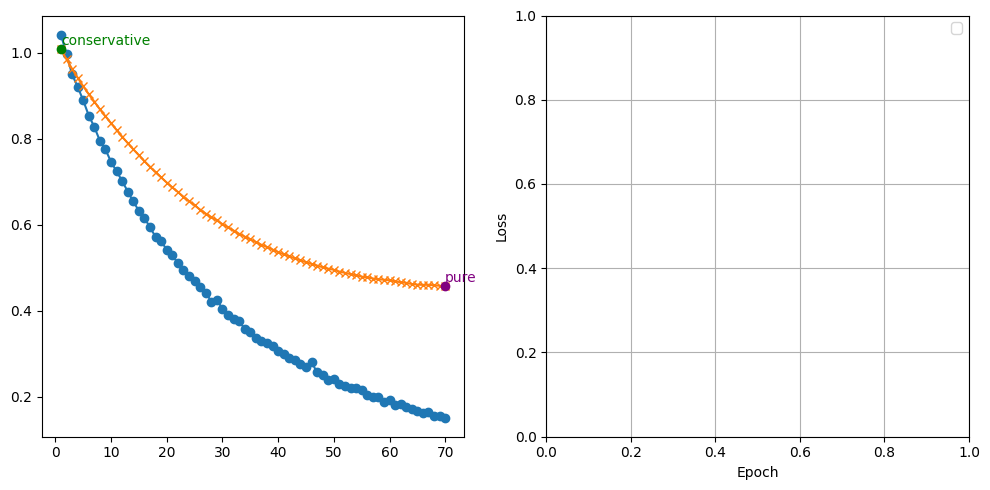

<Figure size 640x480 with 0 Axes>

In [102]:
all_train, all_val, best_pure_epochs, best_cons_epochs = [], [], [], []

for iteration_list in pure_vs_conservative:
    # Third item
    all_train.append(iteration_list[2])

    # Fourth item
    all_val.append(iteration_list[3])

    # 2nd position of both first and second items
    best_pure_epochs.append(iteration_list[0][1])
    best_cons_epochs.append(iteration_list[1][1])


plotLossCollection(all_train, all_val, best_pure_epochs, best_cons_epochs)

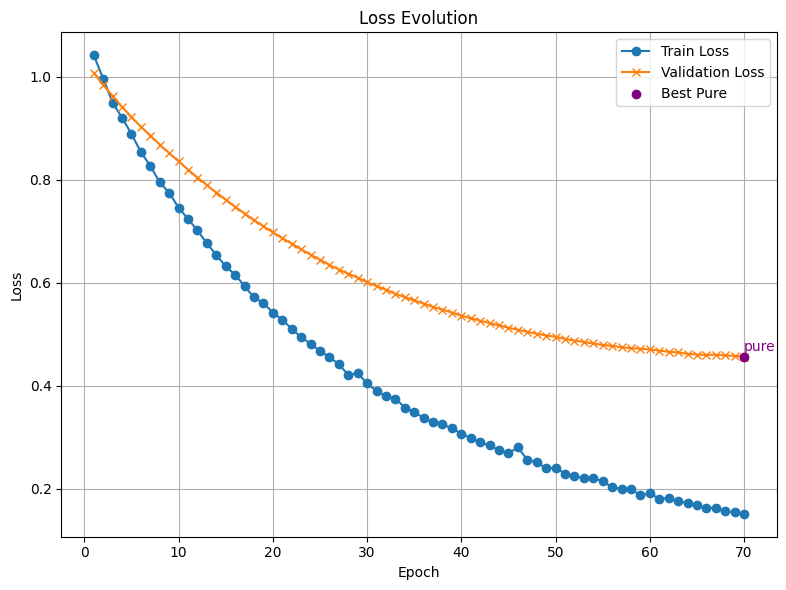

In [72]:
custom_loss = pure_vs_conservative[0][2]
custom_val_loss = pure_vs_conservative[0][3]

epoch_pure = pure_vs_conservative[0][0][1]

plotLoss(custom_loss, custom_val_loss, epoch_pure, pure_vs_conservative[0][1][1])

In [76]:
print(custom_loss[40], custom_val_loss[40])
print(custom_loss[60], custom_val_loss[60])

0.29877211451530455 0.5311711091886867
0.18102264566854998 0.46848510070280597


In [77]:
resnet_custom = pure_vs_conservative[0][0][0]

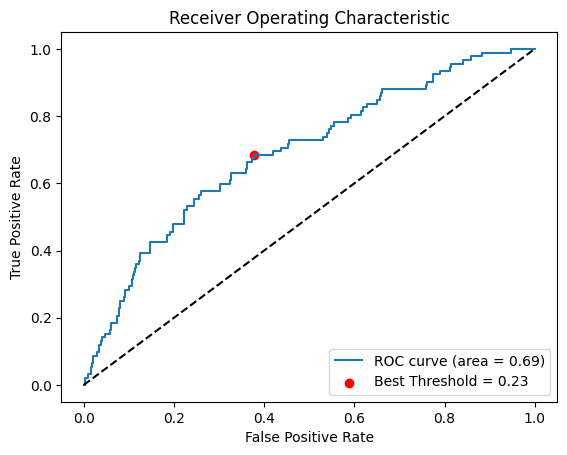

Area Under Curve: 0.6905138339920949
Best Threshold (closest to (0,1)): 0.22598197


In [78]:
threshold_custom, auc_custom = getROC(resnet_custom, val_dataset)

In [79]:
evalResNet(resnet_custom, test_dataset,threshold_custom)

Total examples: 648

 --------------------- 

Accuracy for Class 0: 56.48%  (318 in 563)
Accuracy for Class 1: 85.88%  (73 in 85)
Test Accuracy: 60.34%
Weighted Accuracy: 81.97%

 --------------------- 

F1 Score (Macro): 0.537
F1 Score (Weighted): 0.666
F1 Score Class 0: 0.712
F1 Score Class 1: 0.362

 --------------------- 


Confusion Matrix: 
 [[318 245]
 [ 12  73]]


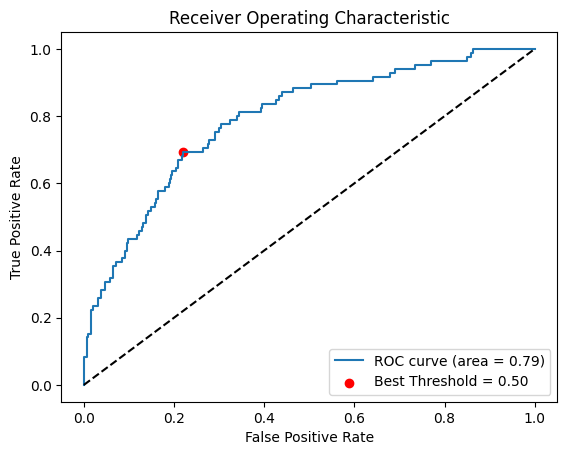

Area Under Curve: 0.791599623863755
Best Threshold (closest to (0,1)): 0.5029546


(np.float32(0.5029546), np.float64(0.791599623863755))

In [80]:
getROC(resnet_custom, test_dataset)